# Exploratory Data Analysis - LendingClub Dataset

## Project: Alternative Credit Scoring Platform

This notebook performs initial exploratory data analysis on the LendingClub dataset to understand the features, distributions, and data quality issues. The dataset contains information about loans issued between 2007 and 2018, with a target variable indicating whether a loan defaulted or not.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set up plotting styles
plt.style.use('default')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Set plotting options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Load the Dataset

Let's load the LendingClub dataset and examine its basic structure.

In [2]:
# Load the dataset
df = pd.read_csv('../data/raw/LC_loans_granting_model_dataset.csv')

# Display basic information about the dataset
print('Dataset shape:', df.shape)
print('\nDataset info:')
df.info()

Dataset shape: (1347681, 15)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347681 entries, 0 to 1347680
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1347681 non-null  int64  
 1   issue_d           1347681 non-null  object 
 2   revenue           1347681 non-null  float64
 3   dti_n             1347681 non-null  float64
 4   loan_amnt         1347681 non-null  int64  
 5   fico_n            1347681 non-null  float64
 6   experience_c      1347681 non-null  int64  
 7   emp_length        1347681 non-null  object 
 8   purpose           1347681 non-null  object 
 9   home_ownership_n  1347681 non-null  object 
 10  addr_state        1347681 non-null  object 
 11  zip_code          1347680 non-null  object 
 12  Default           1347681 non-null  int64  
 13  title             1331024 non-null  object 
 14  desc              119099 non-null   object 
dtypes: fl

In [3]:
# Display the first few rows
df.head()

,id,issue_d,revenue,dti_n,loan_amnt,fico_n,experience_c,emp_length,purpose,home_ownership_n,addr_state,zip_code,Default,title,desc
0,68407277,Dec-2015,55000.0,5.91,3600,677.0,1,10+ years,debt_consolidation,MORTGAGE,PA,190xx,0,Debt consolidation,NaN
1,68355089,Dec-2015,65000.0,16.06,24700,717.0,1,10+ years,small_business,MORTGAGE,SD,577xx,0,Business,NaN
2,68341763,Dec-2015,71000.0,13.85,20000,697.0,1,10+ years,home_improvement,MORTGAGE,IL,605xx,0,NaN,NaN
3,68476807,Dec-2015,104433.0,25.37,10400,697.0,1,3 years,major_purchase,MORTGAGE,PA,174xx,0,Major purchase,NaN
4,68426831,Dec-2015,34000.0,10.20,11950,692.0,1,4 years,debt_consolidation,RENT,GA,300xx,0,Debt consolidation,NaN


In [4]:
# Display basic statistics
df.describe()

,id,revenue,dti_n,loan_amnt,fico_n,experience_c,Default
count,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06,1.347681e+06
mean,5.621359e+07,7.736968e+04,1.829909e+01,1.440823e+04,6.981589e+02,9.999814e-01,1.997869e-01
std,3.839501e+07,7.036299e+04,1.115214e+01,8.715347e+03,3.184872e+01,4.306977e-03,3.998402e-01
min,5.473400e+04,1.896000e+03,0.000000e+00,5.000000e+02,6.120000e+02,0.000000e+00,0.000000e+00
25%,1.970651e+07,4.660000e+04,1.182000e+01,7.975000e+03,6.720000e+02,1.000000e+00,0.000000e+00
50%,5.766422e+07,6.500000e+04,1.763000e+01,1.200000e+04,6.920000e+02,1.000000e+00,0.000000e+00
75%,8.449505e+07,9.200000e+04,2.407000e+01,2.000000e+04,7.120000e+02,1.000000e+00,0.000000e+00
max,1.456364e+08,1.099920e+07,9.990000e+02,4.000000e+04,8.475000e+02,1.000000e+00,1.000000e+00


## Dataset Overview

Based on the information from Zenodo, this dataset has been specifically prepared for granting models that make decisions on loan approval based on information available at application time. It includes loans with final status (either "Fully Paid" or "Default") to avoid data leakage.

**Target Variable**: Default (binary)
- 0 = Fully Paid
- 1 = Default (charged off)

### Features

1. **Loan Identification**: `id`, `issue_d`
2. **Quantitative Variables**: `revenue`, `dti_n`, `loan_amnt`, `fico_n`, `experience_c`
3. **Categorical Variables**: `emp_length`, `purpose`, `home_ownership_n`, `addr_state`, `zip_code`
4. **Textual Variables**: `title`, `desc`

## Target Variable Analysis

Let's examine the distribution of the target variable to understand the class balance.

Target variable distribution:
Default
0    1078432
1     269249
Name: count, dtype: int64

Target variable percentages:
Default
0    80.021311
1    19.978689
Name: proportion, dtype: float64


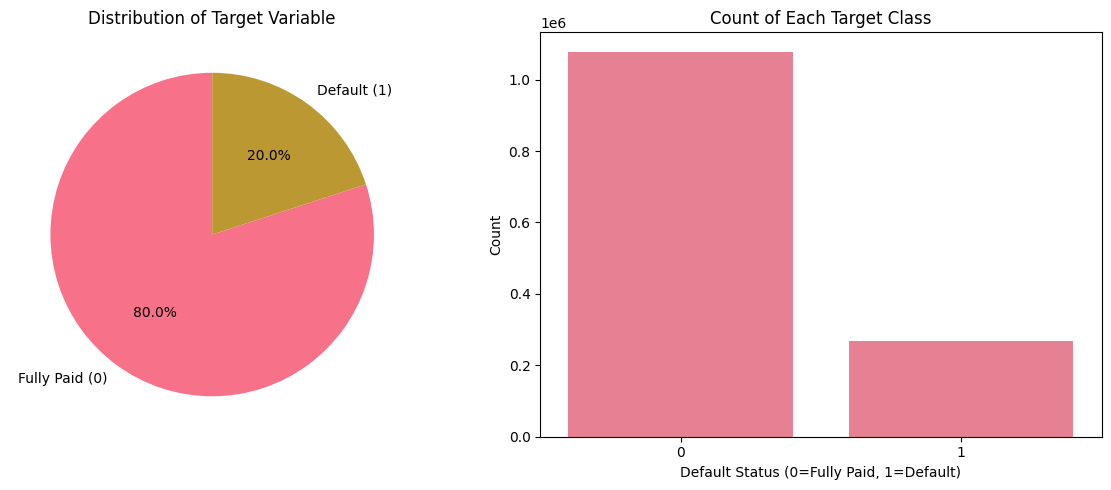

In [5]:
# Analyze the target variable distribution
target_counts = df['Default'].value_counts()
target_percentages = df['Default'].value_counts(normalize=True) * 100

print('Target variable distribution:')
print(target_counts)
print('\nTarget variable percentages:')
print(target_percentages)

# Visualize the target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(target_counts.values, labels=['Fully Paid (0)', 'Default (1)'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Default')
plt.title('Count of Each Target Class')
plt.xlabel('Default Status (0=Fully Paid, 1=Default)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Missing Values Analysis

Let's check for missing values in the dataset.

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Percentage', ascending=False)

print('Features with missing values (top 10):')
print(missing_df[missing_df['Missing Count'] > 0].head(10))

Features with missing values (top 10):
          Missing Count  Missing Percentage
desc            1228582           91.162671
title             16657            1.235975
zip_code              1            0.000074


## Numerical Features Analysis

Let's examine the distributions of numerical features and their relationship with the target variable.

In [7]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Default')  # Remove target variable from numerical columns

print('Numerical features:', numerical_cols)

Numerical features: ['id', 'revenue', 'dti_n', 'loan_amnt', 'fico_n', 'experience_c']


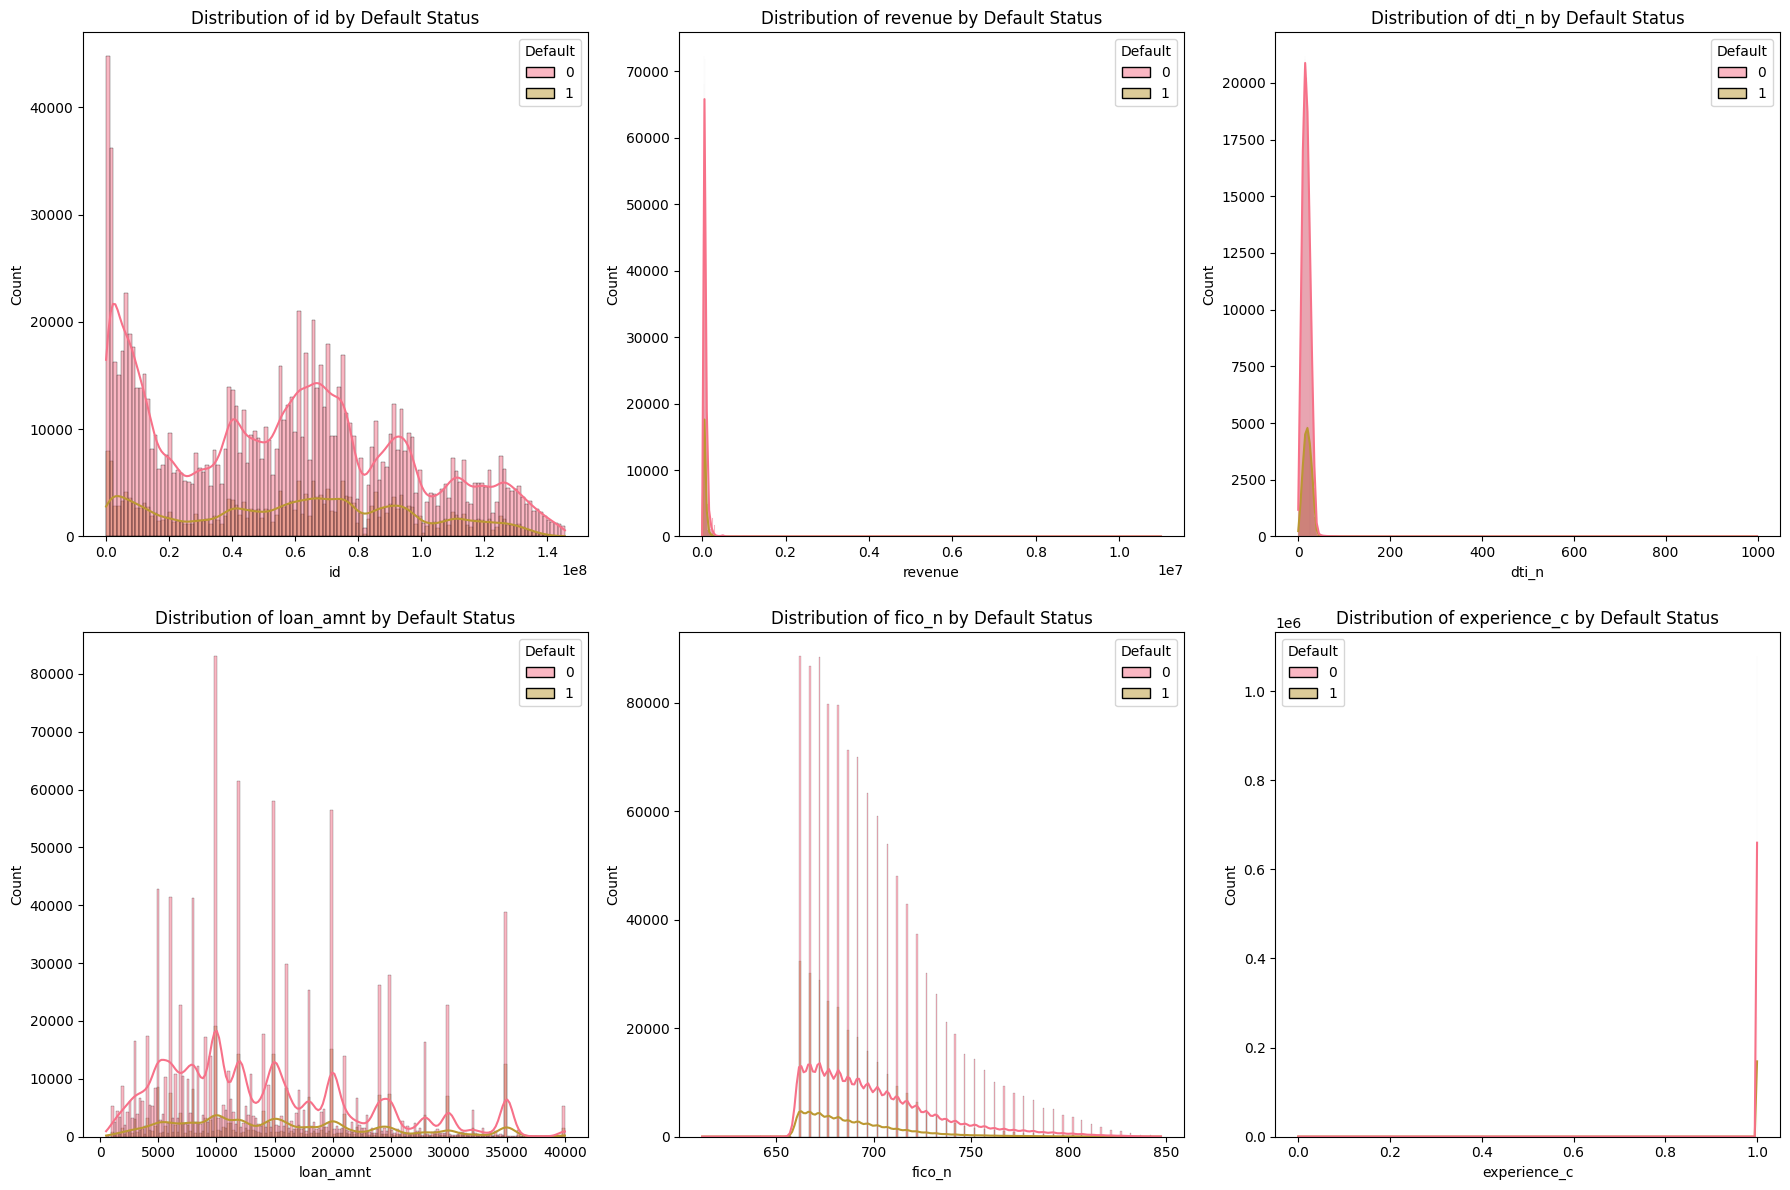

In [8]:
# Distribution plots for numerical features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    if i >= len(axes):
        break
        
    # Plot distribution by target
    sns.histplot(data=df, x=col, hue='Default', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Default Status')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide unused subplots
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [9]:
# Statistical summary of numerical features by target
numerical_stats = df.groupby('Default')[numerical_cols].describe()
print('Statistical summary by Default status:')
numerical_stats

Statistical summary by Default status:


id                                                   \
             count          mean           std      min         25%   
Default                                                               
0        1078432.0  5.527659e+07  3.869263e+07  54734.0  17694311.5   
1         269249.0  5.996659e+07  3.694166e+07  56121.0  29584446.0   

                                                revenue                \
                50%         75%          max      count          mean   
Default                                                                 
0        56070079.0  83153604.5  145636374.0  1078432.0  78785.658732   
1        61842857.0  88087453.0  145455851.0   269249.0  71698.229044   

                                                                      \
                  std     min      25%      50%      75%         max   
Default                                                                
0        71361.973858  1896.0  48000.0  66000.0  95000.0  10999200.0   
1        65906.690086  2000.0  44446.0  60000.0  85000.0   9500000.0   

             dti_n                                                         \
             count       mean        std  min    25%    50%    75%    max   
Default                                                                     
0        1078432.0  17.825246  10.928723  0.0  11.45  17.12  23.45  999.0   
1         269249.0  20.196998  11.816450  0.0  13.59  19.79  26.33  999.0   

         loan_amnt                                                     \
             count          mean          std    min     25%      50%   
Default                                                                 
0        1078432.0  14123.911174  8667.312091  500.0  7500.0  12000.0   
1         269249.0  15547.024130  8813.700142  500.0  9000.0  14300.0   

                              fico_n                                       \
             75%      max      count        mean        std    min    25%   
Default                                                                     
0        20000.0  40000.0  1078432.0  700.239519  32.829891  612.0  677.0   
1        20400.0  40000.0   269249.0  689.825440  25.949533  617.0  672.0   

                             experience_c                                     \
           50%    75%    max        count      mean       std  min  25%  50%   
Default                                                                        
0        692.0  717.0  847.5    1078432.0  0.999980  0.004517  0.0  1.0  1.0   
1        682.0  702.0  847.5     269249.0  0.999989  0.003338  0.0  1.0  1.0   

                   
         75%  max  
Default            
0        1.0  1.0  
1        1.0  1.0

## Categorical Features Analysis

Let's examine the categorical features and their relationship with the target variable.

In [10]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print('Categorical features:', categorical_cols)

Categorical features: ['issue_d', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state', 'zip_code', 'title', 'desc']


In [11]:
# Analyze categorical features
for col in categorical_cols:
    print(f'\nFeature: {col}')
    print(f'Unique values: {df[col].nunique()}')
    print('Top 10 values:')
    print(df[col].value_counts().head(10))
    
    # Create a cross-tabulation with the target variable
    crosstab = pd.crosstab(df[col], df['Default'], normalize='index') * 100
    print('\nPercentage of defaults by category (top 10):')
    print(crosstab.sort_values(by=1, ascending=False).head(10))
    print('-' * 50)


Feature: issue_d
Unique values: 139
Top 10 values:
issue_d
Mar-2016    48927
Oct-2015    42986
Jul-2015    41053
Dec-2015    39001
Oct-2014    36072
Feb-2016    34597
Nov-2015    32907
Jan-2015    32216
Apr-2015    31785
Aug-2015    31701
Name: count, dtype: int64

Percentage of defaults by category (top 10):
Default           0          1
issue_d                       
Oct-2007  67.619048  32.380952
Nov-2007  69.642857  30.357143
Aug-2007  72.222222  27.777778
Jan-2008  72.459016  27.540984
Dec-2007  72.674419  27.325581
Jul-2016  73.388879  26.611121
May-2016  73.826356  26.173644
Aug-2016  73.843113  26.156887
Apr-2016  74.393128  25.606872
Sep-2017  75.029913  24.970087
--------------------------------------------------

Feature: emp_length
Unique values: 12
Top 10 values:
emp_length
10+ years    442667
2 years      122091
< 1 year     108517
3 years      107862
1 year        88841
5 years       84326
4 years       80761
NI            78188
6 years       62877
8 years       60808


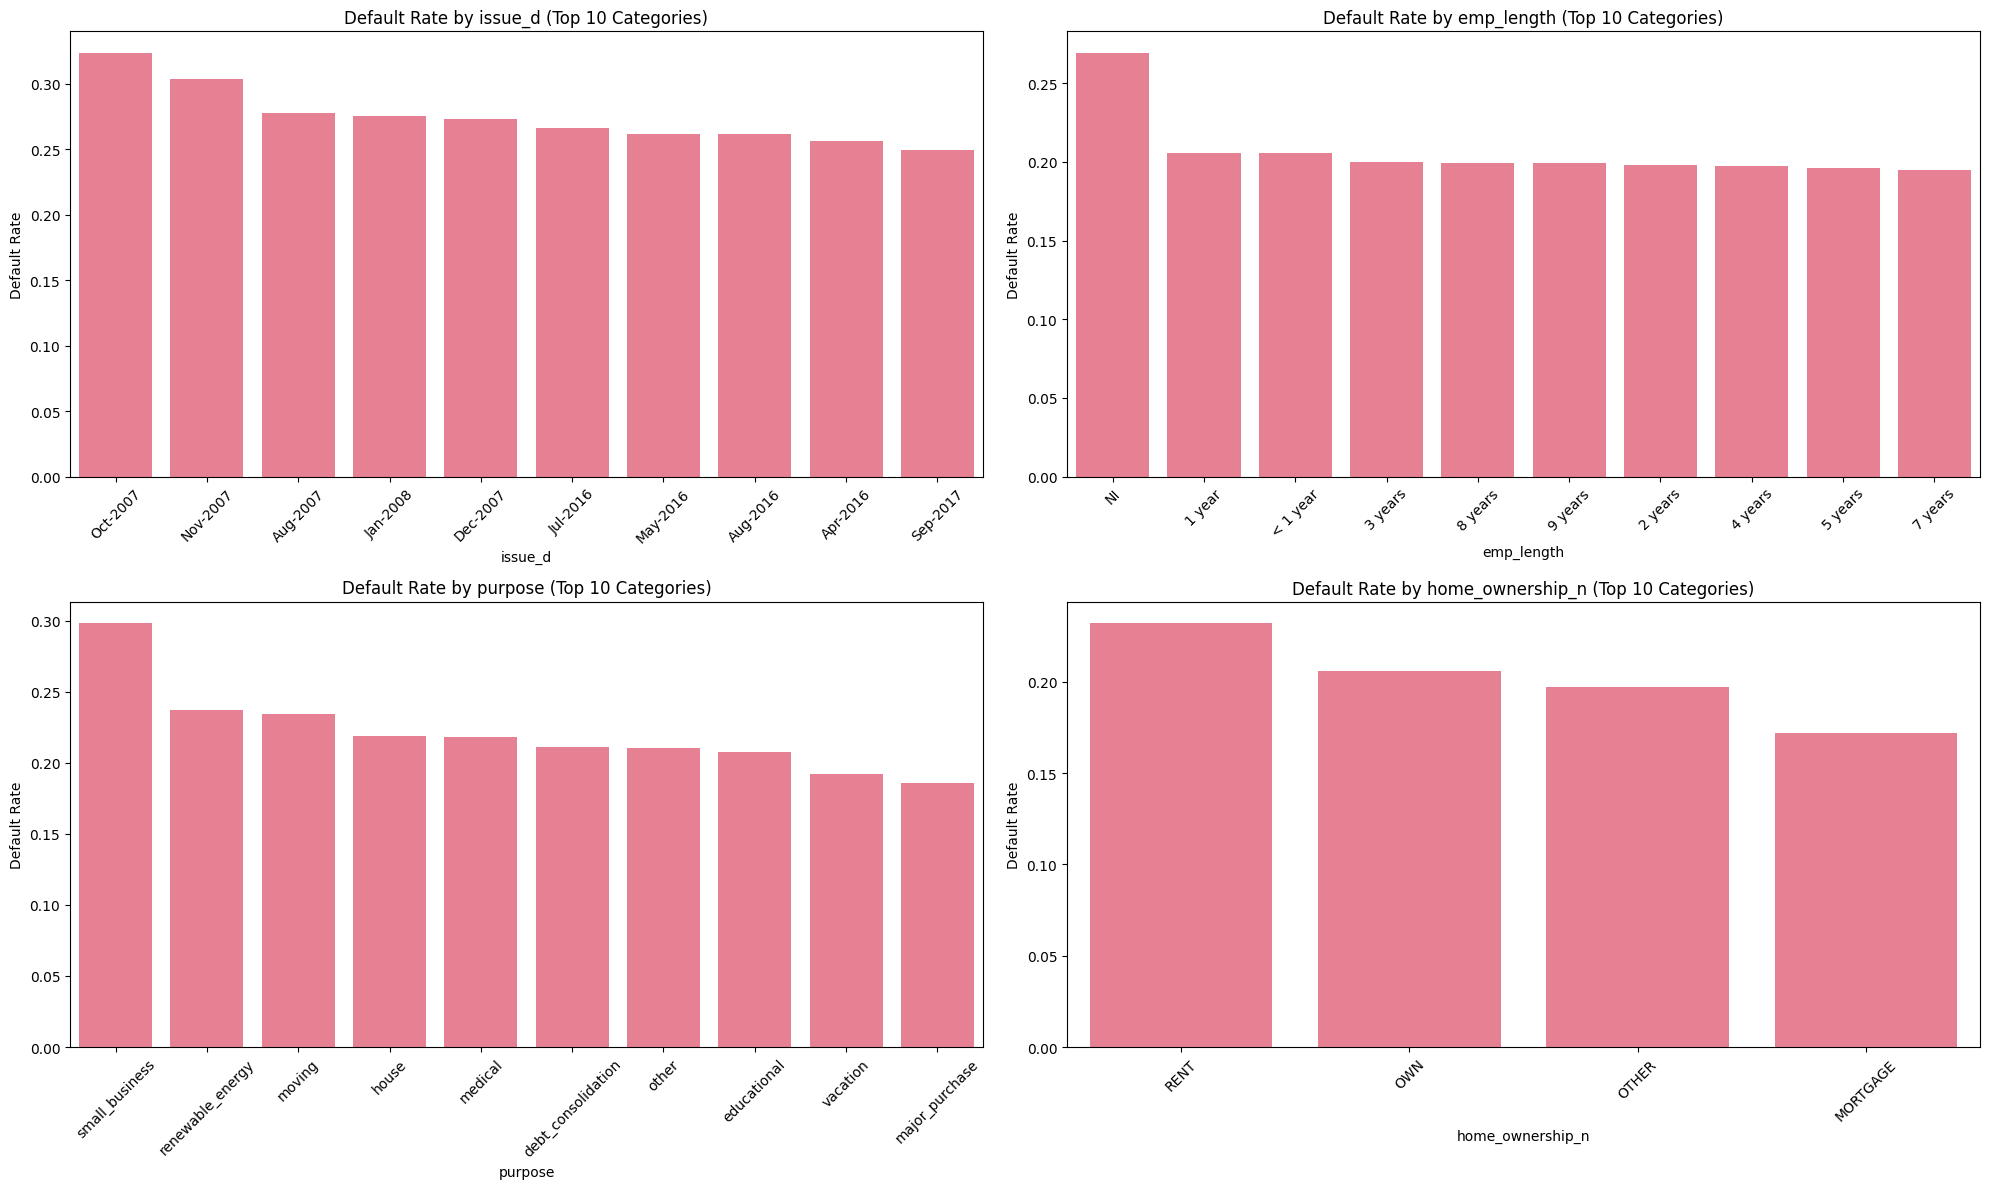

In [12]:
# Visualize categorical features vs target
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols[:4]):  # Show top 4 categorical features
    # Calculate default rate by category
    default_rate = df.groupby(col)['Default'].mean().sort_values(ascending=False)
    
    # Create bar plot
    sns.barplot(x=default_rate.index[:10], y=default_rate.values[:10], ax=axes[i])
    axes[i].set_title(f'Default Rate by {col} (Top 10 Categories)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Default Rate')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Feature Correlations

Let's examine correlations between numerical features to identify potential multicollinearity issues.

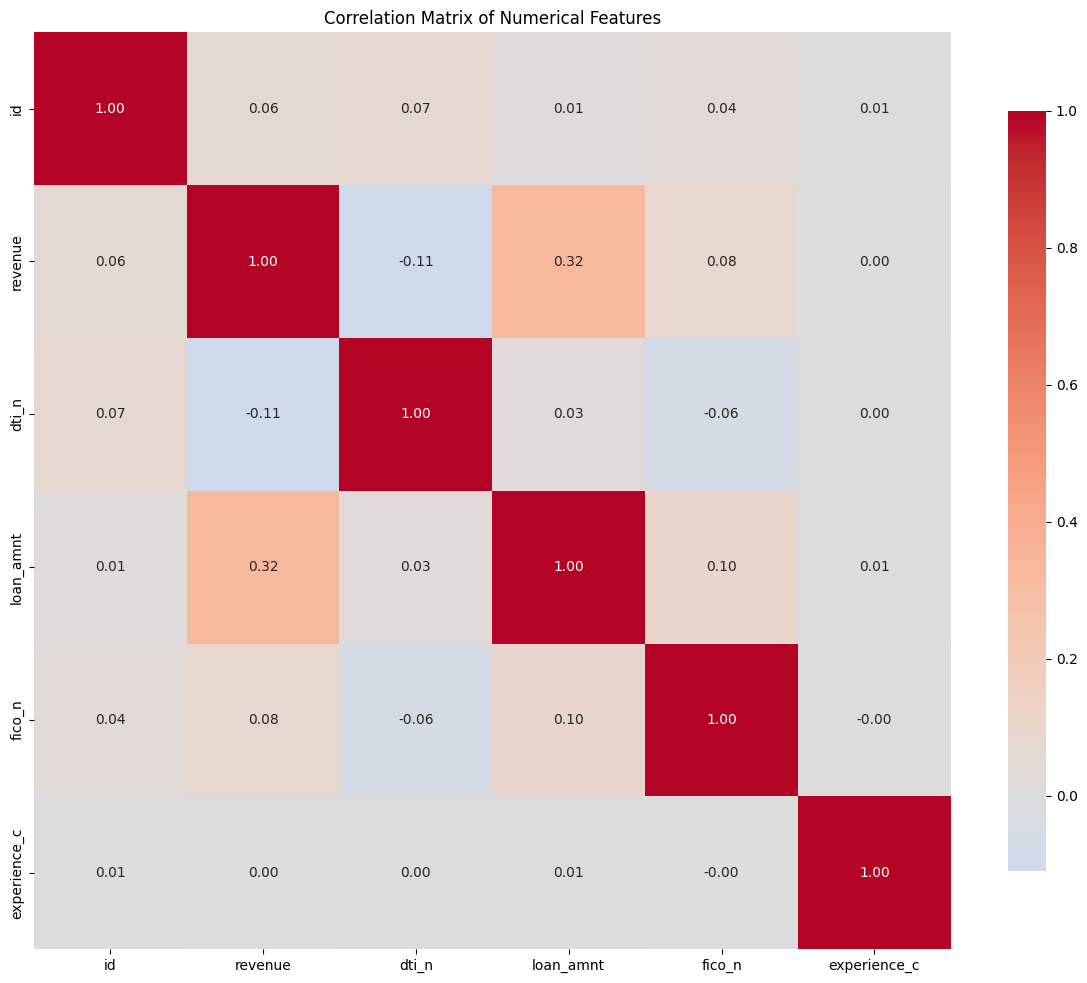

In [13]:
# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## Data Quality Issues

Let's check for potential data quality issues such as outliers, inconsistent values, etc.

In [14]:
# Check for outliers in numerical features using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Check outliers for each numerical feature
for col in numerical_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f'{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}% of data)')

id: 0 outliers (0.00% of data)
revenue: 62998 outliers (4.67% of data)
dti_n: 5506 outliers (0.41% of data)
loan_amnt: 7131 outliers (0.53% of data)
fico_n: 46490 outliers (3.45% of data)
experience_c: 25 outliers (0.00% of data)


## Key Findings and Hypotheses

### Initial Findings:
1. **Dataset Size**: The dataset contains 1,347,681 records with 15 features
2. **Target Distribution**: The dataset is imbalanced with 80.02% of loans being fully paid and 19.98% defaulting
3. **Missing Values**: The 'desc' field has 91.16% missing values, 'title' has 1.24% missing values, and 'zip_code' has 0.000074% missing values
4. **Feature Relationships**: 
   - FICO scores appear to be lower for defaulted loans
   - Debt-to-income ratios may be higher for defaulted loans
   - Loan amounts seem to have similar distributions for both classes

### Hypotheses:
1. **FICO Score**: Lower FICO scores are likely associated with higher default rates
2. **Debt-to-Income Ratio**: Higher DTI ratios may correlate with increased default risk
3. **Loan Amount**: The relationship between loan amount and default risk may be complex
4. **Employment Length**: Shorter employment history might indicate higher risk
5. **Purpose**: Loan purpose may affect default rates (e.g. debt consolidation vs. small business)

### Data Quality Notes:
- The 'desc' field has a very high percentage of missing values and might need to be dropped or imputed
- The 'id' field is likely just an identifier and may not be predictive
- The 'revenue' field has some extreme outliers that might need to be handled
- The 'fico_n' and 'dti_n' features appear to be normalized as suggested by their names ('_n' suffix)

### Next Steps:
1. Perform feature engineering to create additional predictive features
2. Address missing values and outliers
3. Prepare data for modeling
4. Develop baseline models for comparison